In [1]:
pth_filepath = "efficientnet_best.pth"

-----

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os
from torchmetrics import F1Score

In [3]:
file_name, _ = os.path.splitext(pth_filepath)
plot_filepath = file_name + '.png'

In [4]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
train_dir_path = '../../input/data/train/'
train_image_path = '../..//input/data/train/images/'
dt_train = pd.read_csv(train_dir_path+'train.csv')

In [6]:
def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2

In [7]:
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))

In [8]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])

In [9]:
valid_image = []
valid_label = []

for idx in valid_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        _, file_extension = os.path.splitext(file_name)
        if file_extension not in ['.jpg', '.jpeg', '.png']:
            continue
        valid_image.append(train_image_path+path+'/'+file_name)
        valid_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))                                 

In [10]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [11]:
valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [12]:
from PIL import Image

class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data
        self.label = label
        self.transform = transform

        if encoding:
            self.label = self.label.apply(onehot_enc)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = Image.open(self.data[idx])
        X = X.crop((17, 70, 367, 420))
        X = self.transform(X)
        y = self.label[idx]
        return X, y

In [13]:
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [14]:
batch_size = 256
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, num_workers=2)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

#model = torchvision.models.resnet34(pretrained=True)
#model = torch.load("resnet50_kfold_checkpoint_best.pth")
model = torch.load(pth_filepath)
model.to(device)

criterion = nn.CrossEntropyLoss()

class_num = 18
f1 = F1Score(num_classes=class_num, average='macro').to(device)

using cuda:0


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    val_loss_items = []
    val_acc_items = []
    for val_batch in val_dataloader_mask:
        inputs, labels = val_batch
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

len(y_pred)

3780

In [17]:
classes = ('O:M:29','O:M:45','O:M:60',
           'O:F:29','O:F:45','O:F:60',
           'c:M:29','c:M:45','c:M:60',
           'c:F:29','c:F:45','c:F:60',
           '.:M:29','.:M:45','.:M:60',
           '.:F:29','.:F:45','.:F:60')

cf_matrix = confusion_matrix(y_true, y_pred)
#cf_matrix

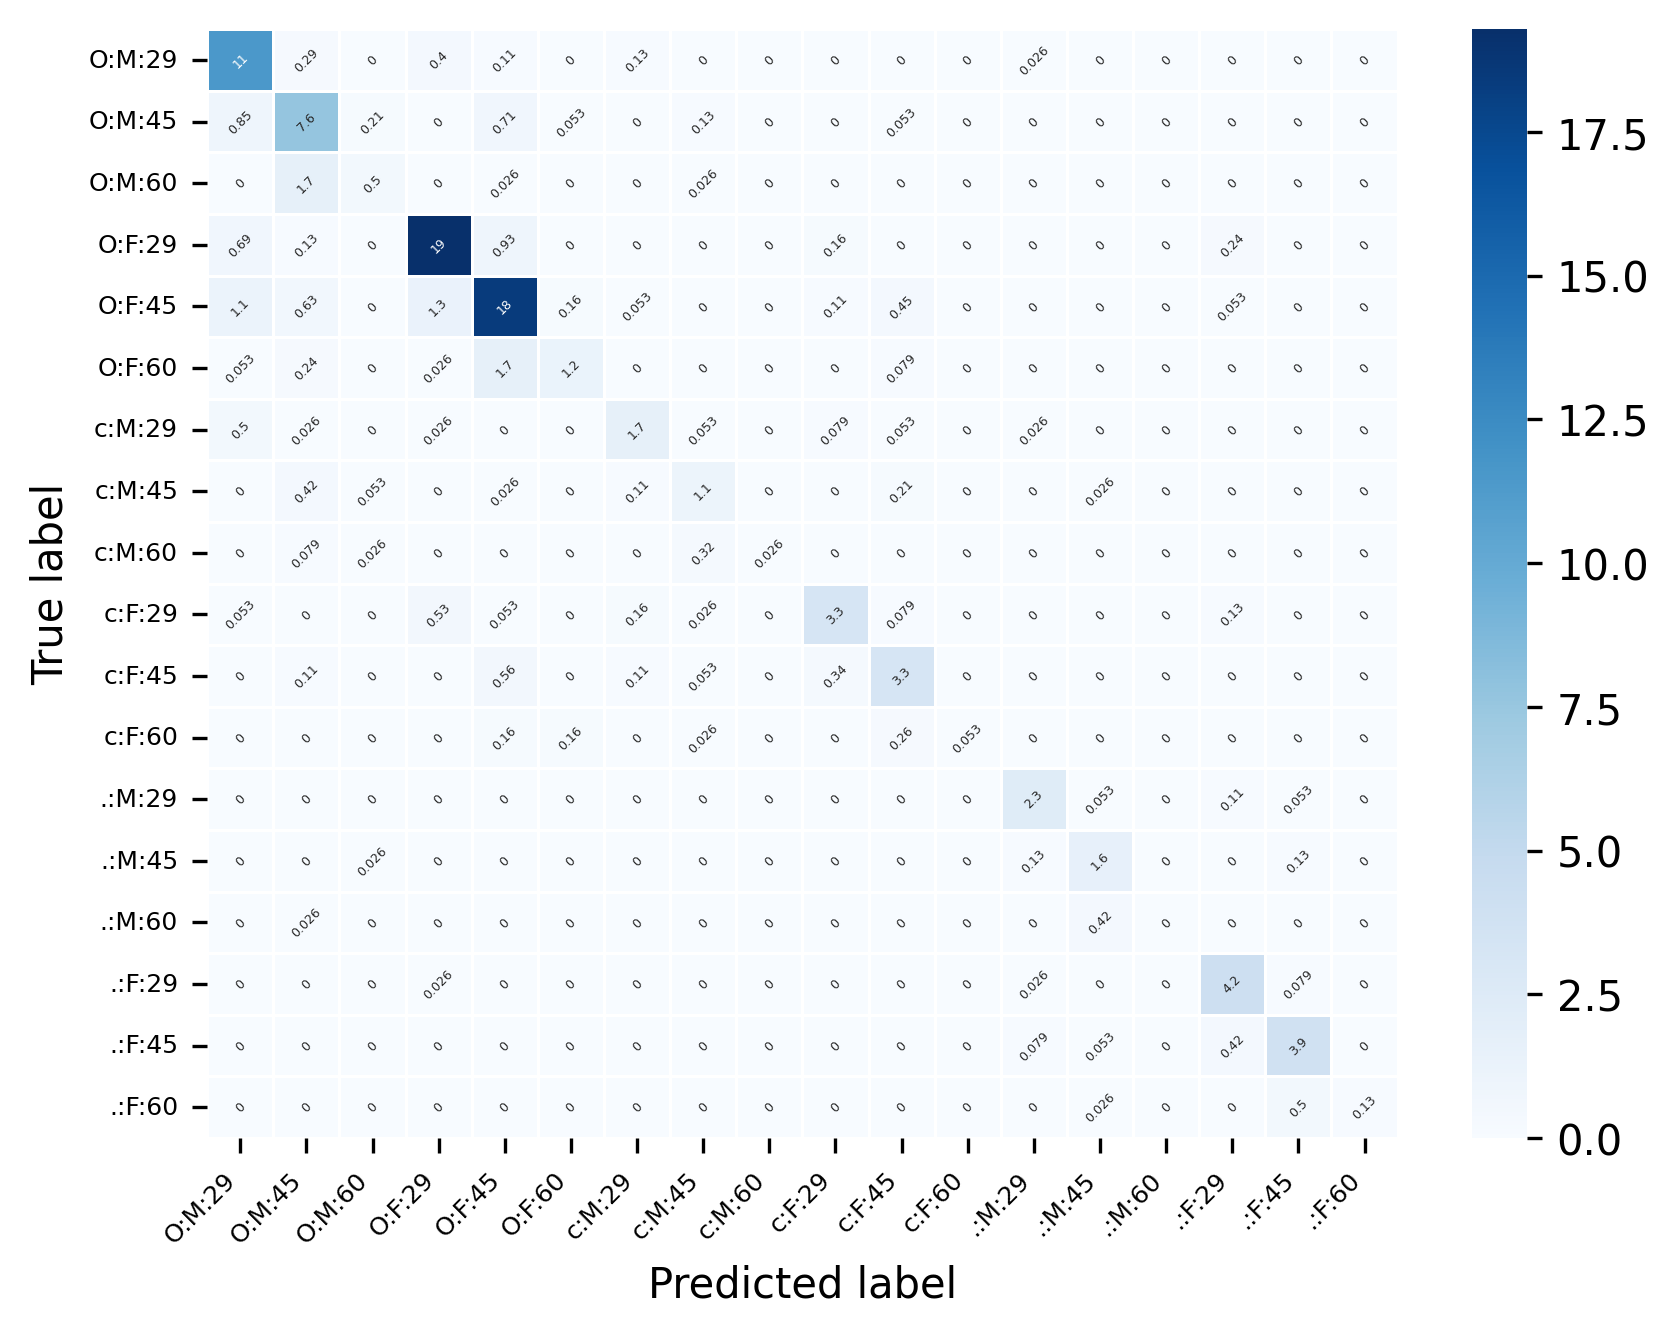

In [18]:
plt.rcParams['figure.dpi'] = 300

df_cm = pd.DataFrame((cf_matrix/np.sum(cf_matrix)*100), # .astype(int)
#df_cm = pd.DataFrame(cf_matrix, # .astype(int)
                     index = [i for i in classes],
                     columns = [i for i in classes])

heatmap = sn.heatmap(df_cm,
                     linewidths=.3,
                     cmap="Blues",
                     annot=True,
                     annot_kws={"size": 3, "rotation": 45}
                    )

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=6)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=6)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig(plot_filepath)
plt.show()